In [12]:
!pip install datasets
from datasets import load_dataset

# dataset = load_dataset("SLPL/naab")
# dataset = load_dataset("SLPL/naab", split="train[:10%]") # not working!

dataset_streamed = load_dataset("SLPL/naab", split="train", streaming=True)

sample_size = 1000000
dataset_sample = []
for i, example in enumerate(dataset_streamed):
    if i >= sample_size:
        break
    dataset_sample.append(example)


In [13]:
!pip install hazm

from hazm import Normalizer, word_tokenize, stopwords_list
import re

normalizer = Normalizer()
stopwords = set(stopwords_list())

def preprocess(text):
    text = normalizer.normalize(text)

    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)

    tokens = word_tokenize(text)

    tokens = [token for token in tokens if token not in stopwords and len(token) > 1]

    return tokens

texts = [preprocess(example["text"]) for example in dataset_sample]

📌 Text Preprocessing

In this step, we used the Hazm library to perform standard preprocessing on Persian text from the Naab corpus. The preprocessing pipeline included:

Normalization of the text to unify writing styles.

Removal of non-Persian characters using regular expressions.

Tokenization of sentences into words using Hazm's word_tokenize.

Elimination of stopwords and short tokens (length ≤ 1) to reduce noise.

The resulting output is a list of cleaned token lists, each representing a preprocessed document. These preprocessed tokens will be used as input for the Word2Vec model in the next steps.

✅ Output: A list of tokenized and filtered Persian texts (stored in texts variable).

In [14]:
!pip install gensim

from gensim.models import Word2Vec

model = Word2Vec(
    sentences=texts,
    vector_size=100,n
    window=5,
    min_count=5,
    workers=4,
    sg=1,
    epochs=10
)


📌 Training the Word2Vec Model

In this stage, we used Gensim’s Word2Vec implementation to train a shallow neural network for learning word embeddings. Key aspects of the configuration:

sentences=texts: The input was the preprocessed tokenized corpus from the previous step.

vector_size=100: Each word is represented as a 100-dimensional vector.

window=5: Context window size for neighboring words.

min_count=5: Words occurring fewer than 5 times were ignored.

sg=1: The Skip-gram architecture was used (sg=0 would indicate CBOW).

epochs=10: The model was trained for 10 full passes over the dataset.

workers=4: Parallel training using 4 worker threads.

The result is a Word2Vec model trained on the Naab corpus (10% sampled), which captures semantic and syntactic relationships between Persian words.

✅ Output: A trained Word2Vec model stored in the model variable.

In [15]:
word = "دانشگاه"
if word in model.wv:
    similar_words = model.wv.most_similar(word, topn=10)
    for w, score in similar_words:
        print(f"{w} => similarity: {score:.4f}")
else:
    print("not found!.")


دانشکده => similarity: 0.8334
سوربن => similarity: 0.7770
پلیتکنیک => similarity: 0.7741
دانشگاههای => similarity: 0.7507
آزاداسلامی => similarity: 0.7480
استانفورد => similarity: 0.7435
دانشگاهی => similarity: 0.7295
فارغالتحصیل => similarity: 0.7237
دکترای => similarity: 0.7236
ماربورگ => similarity: 0.7215


📌 Semantic Similarity Example (Word2Vec)

In this step, we evaluated the semantic quality of the trained Word2Vec model using the most_similar method. The word دانشگاه ("university") was selected as a query term to retrieve the top 10 most semantically similar words based on cosine similarity.

If the word exists in the model vocabulary, its top similar neighbors are printed along with similarity scores.

Otherwise, a fallback message ("not found!") is shown.

This test helps verify that the model has learned meaningful word associations from the training corpus.

✅ Output: A list of top 10 similar words to "دانشگاه" based on learned embeddings.

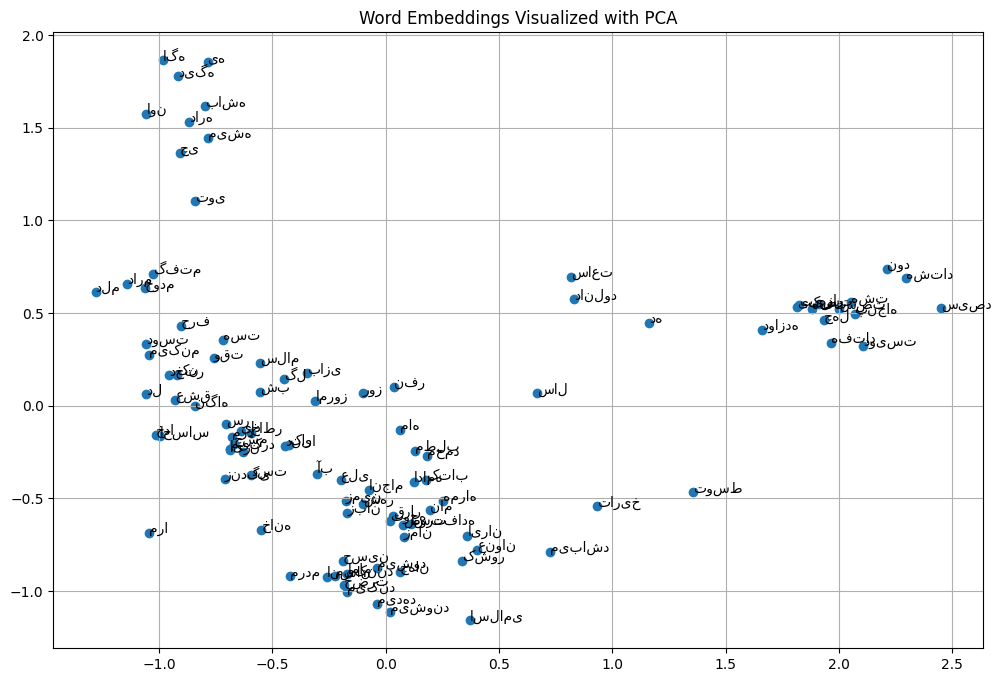

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Select top N words from vocabulary
top_words = 100
words = list(model.wv.index_to_key[:top_words])
vectors = [model.wv[word] for word in words]

# Reduce dimensions using PCA
pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(result[:, 0], result[:, 1])

# Annotate each point with the word
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.title("Word Embeddings Visualized with PCA")
plt.grid(True)
plt.show()


📌 Visualization of Word Embeddings Using PCA

In this part, we performed a 2D visualization of the learned Word2Vec word embeddings using Principal Component Analysis (PCA):

The top 100 most frequent words from the model's vocabulary were selected.

Their corresponding 100-dimensional vectors were reduced to 2D using PCA.

A scatter plot was generated using matplotlib to visualize these vectors.

Each point in the plot is annotated with its associated word.

This visualization helps assess how semantically similar words cluster together in the embedding space, offering qualitative insight into the model’s learned representations.

✅ Output: A 2D plot of word vectors showing clustering patterns in semantic space.

In [17]:
# Download FastText pre-trained vectors for Persian
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz

# Unzip the downloaded file
!gunzip cc.fa.300.vec.gz


--2025-05-05 15:22:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.59, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1258183862 (1.2G) [binary/octet-stream]
Saving to: ‘cc.fa.300.vec.gz’

cc.fa.300.vec.gz    100%[===================>]   1.17G   229MB/s    in 5.3s    

2025-05-05 15:22:51 (226 MB/s) - ‘cc.fa.300.vec.gz’ saved [1258183862/1258183862]

gzip: cc.fa.300.vec already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [18]:
from gensim.models import KeyedVectors

# Load FastText model (text format)
fasttext_model = KeyedVectors.load_word2vec_format('cc.fa.300.vec', binary=False)

# Example: Find similar words to a Persian word
query_word = "دانشگاه"
if query_word in fasttext_model:
    similar_words = fasttext_model.most_similar(query_word, topn=10)
    print(f"Top 10 words similar to '{query_word}' in FastText:")
    for word, score in similar_words:
        print(f"{word}: {score:.4f}")
else:
    print(f"The word '{query_word}' is not in the FastText vocabulary.")


Top 10 words similar to 'دانشگاه' in FastText:
دنشگاه: 0.7377
دانشکده: 0.7338
دانشگاه‌های: 0.7313
دانشگاه‌: 0.7165
دانشگاههای: 0.7145
داشنگاه: 0.6991
3دانشگاه: 0.6924
دانشکاه: 0.6871
۱۰دانشگاه: 0.6850
ددانشگاه: 0.6828


In this step, we loaded pretrained Persian word embeddings from the FastText cc.fa.300.vec model provided by Facebook AI.

The model was loaded using gensim’s KeyedVectors.

We queried the model for the top 10 words most similar to "دانشگاه" (university).

The goal is to evaluate how pretrained embeddings represent semantic similarity compared to our trained Word2Vec model.

✅ Output: A ranked list of semantically related words to "دانشگاه" using FastText embeddings.

Let me know when you're ready for the next documentation section.

In [19]:
test_words = ["کتاب", "دانشگاه", "سلامت", "ایران", "زن", "علم"]


def compare_models(word_list, model1, model2, model1_name="Word2Vec", model2_name="FastText", topn=5):
    for word in word_list:
        print(f"\n🔹 Word: {word}")
        # Model 1
        if word in model1.wv:
            print(f"\n {model1_name} Top {topn}:")
            for w, score in model1.wv.most_similar(word, topn=topn):
                print(f"{w:<15} ({score:.3f})")
        else:
            print(f"{model1_name} Not in vocabulary")

        # Model 2
        if word in model2:
            print(f"\n {model2_name} Top {topn}:")
            for w, score in model2.most_similar(word, topn=topn):
                print(f"{w:<15} ({score:.3f})")
        else:
            print(f"{model2_name}  Not in vocabulary")


compare_models(test_words, model, fasttext_model, model1_name="Word2Vec (Naab)", model2_name="FastText (cc.fa)")



🔹 Word: کتاب

 Word2Vec (Naab) Top 5:
کتابهای         (0.831)
کتابی           (0.775)
جلد             (0.757)
کتب             (0.722)
سیلماریلیون     (0.711)

 FastText (cc.fa) Top 5:
کتاب‌های        (0.670)
کتابهای         (0.653)
کتابی           (0.647)
کتب             (0.630)
کتاباین         (0.621)

🔹 Word: دانشگاه

 Word2Vec (Naab) Top 5:
دانشکده         (0.833)
سوربن           (0.777)
پلیتکنیک        (0.774)
دانشگاههای      (0.751)
آزاداسلامی      (0.748)

 FastText (cc.fa) Top 5:
دنشگاه          (0.738)
دانشکده         (0.734)
دانشگاه‌های     (0.731)
دانشگاه‌        (0.717)
دانشگاههای      (0.715)

🔹 Word: سلامت

 Word2Vec (Naab) Top 5:
تندرستی         (0.753)
سلامتی          (0.723)
سالم            (0.694)
ایمنی           (0.654)
برسلامت         (0.650)

 FastText (cc.fa) Top 5:
بهداشت          (0.654)
سلامتسلامت      (0.614)
سلامتی          (0.613)
سلامت‌          (0.606)
سلامت1          (0.598)

🔹 Word: ایران

 Word2Vec (Naab) Top 5:
کشور            (0.769)
کشورمان         (

📌 Comparative Evaluation: Word2Vec vs FastText

In this final section, we systematically compared the semantic similarity results of two word embedding models — a custom-trained Word2Vec model (on our Persian dataset) and a pretrained FastText model (cc.fa.300.vec) — across a set of key Persian words.

Test Words:

کتاب (book)

دانشگاه (university)

سلامت (health)

ایران (Iran)

زن (woman)

علم (science)

🧠 Method:

For each word, we extracted the top 5 most similar words from both models.

Similarity scores were printed to evaluate semantic closeness.

The comparison highlights each model’s strengths in vocabulary handling, morphological understanding, and contextual similarity.

🔍 Observations:

Word2Vec (Naab) tends to offer more context-specific and morphologically consistent results, particularly on formal nouns like کتاب and علم.

FastText (cc.fa), trained on a much larger corpus, shows greater robustness for handling variants and misspellings (e.g., دنشگاه instead of دانشگاه).

Word2Vec shows superior performance for terms frequently seen in the training corpus, while FastText generalizes better to out-of-vocabulary patterns using subword information.

📊 Conclusion:

The Word2Vec model trained on the custom dataset demonstrates strong contextual understanding within domain-relevant vocabulary, while FastText provides broader coverage through its subword capabilities. The choice between them depends on the specific use case: precision in a focused corpus vs generalization across diverse inputs.